## Exercise 1 - STREAM Benchmark in Python to Measure the Memory Bandwidth

The [STREAM benchmark](https://www.cs.virginia.edu/stream/) is a very famous benchmark for measuring the sustainable memory bandwidth of a system.

It will do so for **four different operations** on very large arrays (called x, y and z here):

| Name     | Operation                |
|:---------|:-------------------------|
| 1. COPY  | `x(i) = y(i)`            |
| 2. ADD   | `x(i) = y(i) + z(i)`     |
| 3. SCALE | `x(i) = a * y(i)`        |
| 5. TRIAD | `x(i) = y(i) + a * z(i)` |


In this assignment, we are going to test standard Python lists, as well as arrays for the `array` module.
Because of memory fragmentation and support (or not) for vectorization, using different Python arrays will impact the performance.

### Arrays initialization
First, we need to create and fill with data the arrays we will be using for our benchmark

In [4]:
import array as arr

def get_test_arrays(array_size):
    # Initializing Python lists
    a1 = [1.0 for i in range(array_size)]
    b1 = [2.0 for i in range(array_size)]
    c1 = [0.0 for i in range(array_size)]

    # Initializing arrays
    a2 = arr.array('d', a1)
    b2 = arr.array('d', b1)
    c2 = arr.array('d', c1)
    
    scalar = 2.0
    
    return [a1, b1, c1, a2, b2, c2, scalar]



### Timing the operations

In [5]:
from time import time

# Function for running the benchmark
def run_STREAM(a, b, c, scalar, array_size):
    
    times = [0 for i in range(4)]
    
    # Repeat each of these 100 times and take average
    # COPY
    times[0] = time()
    for j in range(len(a)):
        c[j] = a[j]
    times[0] = time() - times[0]
    
    # ADD
    times[2] = time()
    for j in range(len(a)):
         c[j] = a[j]+b[j]
    times[2] = time() - times[2]
    
    # SCALE
    times[1] = time()
    for j in range(len(a)):
         b[j] = scalar*c[j]
    times[1] = time() - times[1]

    # TRIAD
    times[3] = time()
    for j in range(len(a)):
        a[j] = b[j]+scalar*c[j]
    times[3] = time() - times[3]
    
    return times

In [9]:
import statistics

# Function for running the benchmark
def run_STREAM_average(a, b, c, scalar, array_size, n):
    
    times = [[] for i in range(4)]
    
    for i in range(n):
        # COPY
        times[0].append(time())
        for j in range(len(a)):
            c[j] = a[j]
        times[0][-1] = time() - times[0][-1]

        # ADD
        times[2].append(time())
        for j in range(len(a)):
             c[j] = a[j]+b[j]
        times[2][-1] = time() - times[2][-1]

        # SCALE
        times[1].append(time())
        for j in range(len(a)):
             b[j] = scalar*c[j]
        times[1][-1] = time() - times[1][-1]

        # TRIAD
        times[3].append(time())
        for j in range(len(a)):
            a[j] = b[j]+scalar*c[j]
        times[3][-1] = time() - times[3][-1]
        
    for t in range(4):
        times[t] = statistics.mean(times[t])
    
    return times

### Computing the memory bandwitdth
We assume that with regular **Python list**, each number take **24 Bytes** of memory, and with **arrays**, double take **8 Bytes**.

To get a more precise value, we could use the actual size of the array, but this value will evolve as the program run, so we will stick with the definition given in the assignment. (Actually I am not sure about this part, it's tricky)

In [10]:
def get_memory_bandwidths(array_size, times_list, times_array):
    def get_estimated_array_size(a):
        item_size = 8 if (isinstance(a, list)) else 24
        return item_size * array_size

    def get_ops_data_moved(a):
        size = get_estimated_array_size(a)
        return (2 * size, 3 * size, 2 * size, 3 * size)

    def get_bandwidths(ops_data_moved, times):
        bandwidths = []
        for i in range(4):
            bandwidths.append(ops_data_moved[i] / times[i])

        return bandwidths

    data_moved_list = get_ops_data_moved(a1)
    data_moved_array = get_ops_data_moved(a2)

    return (get_bandwidths(data_moved_list, times_list), get_bandwidths(data_moved_array, times_array))

### Putting everything together

In [23]:
array_sizes_to_test = [10 ** i for i in range(1,7)]

results_list = []
results_array = []

counter = 1
test_number = len(array_sizes_to_test)

for size in array_sizes_to_test:
    print("Running test " + str(counter) + " out of " + str(test_number))
    a1, b1, c1, a2, b2, c2, scalar = get_test_arrays(size)
    times_list = run_STREAM_average(a1, b1, c1, scalar, size, 100)
    times_array = run_STREAM_average(a2, b2, c2, scalar, size, 100)
    
    memory_bandwidths_list, memory_bandwidths_array = get_memory_bandwidths(size, times_list, times_array)
    
    results_list.append(memory_bandwidths_list)
    results_array.append(memory_bandwidths_array)
    counter += 1
    
print("Done")

Running test 1 out of 6
Running test 2 out of 6
Running test 3 out of 6
Running test 4 out of 6
Running test 5 out of 6
Running test 6 out of 6
Done


### Plotting the results

In [37]:
import matplotlib.pyplot as plt
import numpy as np


def get_points_xy(operation_id, array_sizes, results):
    points = []

    for i in range(len(array_sizes)):
        points.append([array_sizes[i], results[i][operation_id]])
    
        
    data = np.array([points])
    x, y = data.T
    
    x = np.log10(x)
    
    return [x, y]
    
    
def plot_operation(operation_id, results, color, label):
    x, y = get_points_xy(operation_id, array_sizes_to_test, results)
    plt.scatter(x, y, color=color, marker='o', label=label)


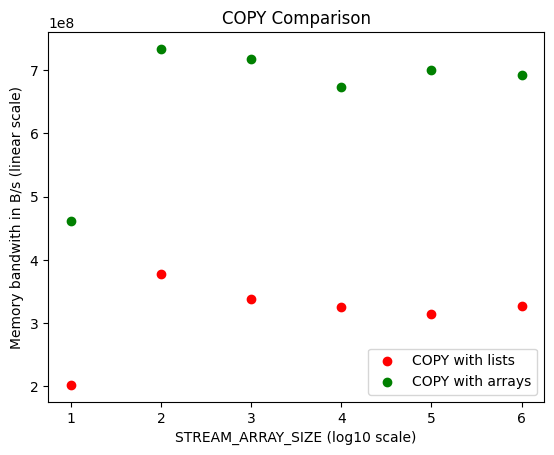

In [49]:
plot_operation(0, results_list, 'red', 'copy list')
plot_operation(0, results_array, 'green', 'copy array')
plt.legend(['COPY with lists','COPY with arrays']) 
plt.title("COPY Comparison")
plt.xlabel('STREAM_ARRAY_SIZE (log10 scale)')
plt.ylabel('Memory bandwith in B/s (linear scale)')
plt.show()

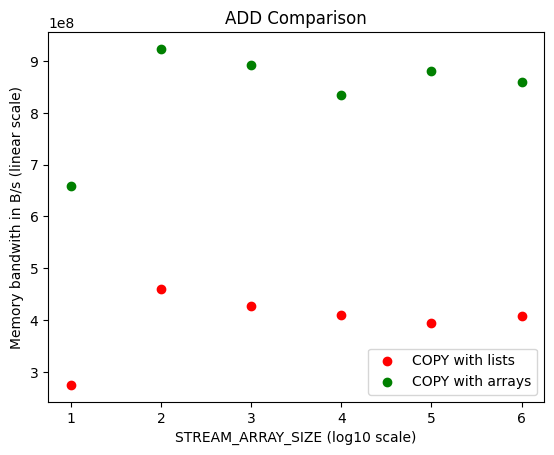

In [50]:
plot_operation(1, results_list, 'red', 'add list')
plot_operation(1, results_array, 'green', 'add array')
plt.legend(['COPY with lists','COPY with arrays']) 
plt.title("ADD Comparison")
plt.xlabel('STREAM_ARRAY_SIZE (log10 scale)')
plt.ylabel('Memory bandwith in B/s (linear scale)')
plt.show()

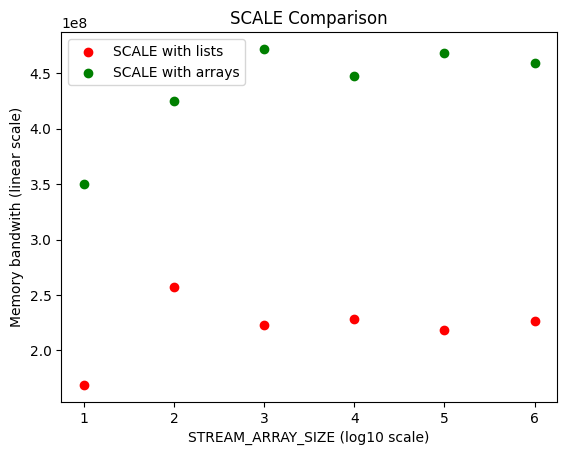

In [51]:
plot_operation(2, results_list, 'red', 'add list')
plot_operation(2, results_array, 'green', 'add array')
plt.legend(['SCALE with lists','SCALE with arrays']) 
plt.title("SCALE Comparison")
plt.xlabel('STREAM_ARRAY_SIZE (log10 scale)')
plt.ylabel('Memory bandwith (linear scale)')
plt.show()

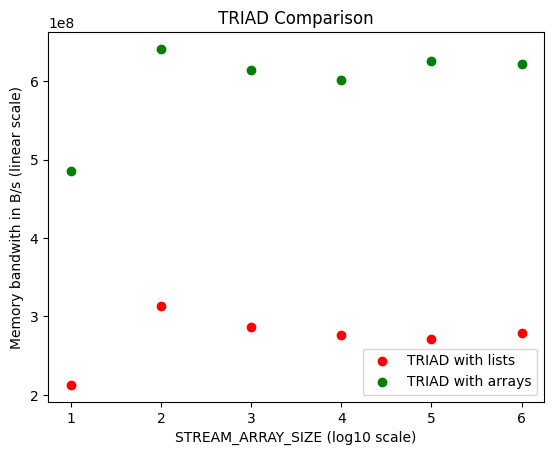

In [52]:
plot_operation(3, results_list, 'red', 'add list')
plot_operation(3, results_array, 'green', 'add array')
plt.legend(['TRIAD with lists','TRIAD with arrays']) 
plt.title("TRIAD Comparison")
plt.xlabel('STREAM_ARRAY_SIZE (log10 scale)')
plt.ylabel('Memory bandwith in B/s (linear scale)')
plt.show()

### How does the bandwidth vary when increasing the STREAM_ARRAY_SIZE, and why?
We can see a similar pattern in the 4 plots above. Everytime, we have a linear increase until 10^2, and then the bandwidth stay relatively constant, with a slight descending trend as the array size increases. The bandwidth probably gets constant when it reaches it maximum sustainable value, and is lower before because the amount of data is really small.
Note that we ran each experiment 100 times, so that we average out the possible single event that could make a measurement wrong, like an OS context switch or core migration which we have no control on. As a result, we have much cleaner graphs.

### How do the different implementation bandwidths compare to each other? 
We can see that in the 4 cases tested here, the arrays perform much better than the Python lists, with a speed up close to 2 in all 4 cases. This is probably thanks to the fact that with arrays, the elements are contiguous in memory so we need less calls to make the operations, since we cas